# Dataset source

## [kaggle face mask detection](https://www.kaggle.com/omkargurav/face-mask-dataset)

In [269]:
import os 
import cv2
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint 
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


In [215]:
tf.__version__

'2.0.0'

In [216]:
#Training data directory
Train_Directory='Train'

In [217]:
os.listdir(Train_Directory)

['0', '1']

# Data Preprocessing

### Train

In [218]:
image_generator = ImageDataGenerator(rescale = 1./255, validation_split= 0.2)

In [225]:
train_generator = image_generator.flow_from_directory(batch_size = 40, directory= Train_Directory, shuffle= True, target_size=(64,64), class_mode = 'categorical', subset="training")

Found 4598 images belonging to 2 classes.


### Validation

# Example of batch of images

In [227]:
train_images, train_labels = next(train_generator)

In [228]:
train_images.shape

(40, 64, 64, 3)

In [229]:
train_labels.shape

(40, 2)

In [230]:
train_labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [232]:
label_names = {0 : 'Without Mask', 1 : 'With Mask'}

In [233]:
val_images, val_labels = next(validation_generator)

In [234]:
val_images.shape

(40, 64, 64, 3)

In [235]:
val_labels.shape

(40, 2)

# Visualize the data

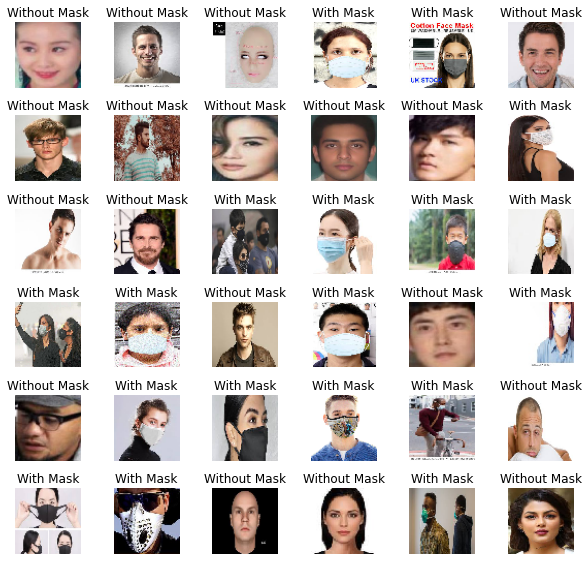

In [238]:
# Create a grid of 36 images along with their corresponding labels
L = 6
W = 6

fig, axes = plt.subplots(L, W, figsize = (10, 10))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5) 

## Building the CNN

In [279]:
cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=[64, 64, 3]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [240]:
cnn.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               802944    
_________________________________________________________________
dense_15 (Dense)             (None, 2)                

In [280]:
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [281]:
# earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)

In [282]:
#### Reduce the batch size for the training
train_generator = image_generator.flow_from_directory(batch_size = 16, directory= Train_Directory, shuffle= True, target_size=(64,64), class_mode = 'binary', subset="training")
validation_generator = image_generator.flow_from_directory(batch_size = 16, directory= Train_Directory, shuffle= False, target_size=(64,64), class_mode = 'binary', subset="validation")

Found 4598 images belonging to 2 classes.
Found 1149 images belonging to 2 classes.


In [283]:
history = cnn.fit_generator(train_generator, 
                              steps_per_epoch= train_generator.n // 20, 
                              epochs = 10, 
                              validation_data= validation_generator, 
                              validation_steps= validation_generator.n // 20, 
                              callbacks=[checkpointer])

Epoch 1/10


F:\Ana3\envs\tensorflow_env\lib\site-packages\PIL\Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


228/229 [============================>.] - ETA: 0s - loss: 0.4540 - accuracy: 0.7777

F:\Ana3\envs\tensorflow_env\lib\site-packages\PIL\Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "



Epoch 00001: val_loss improved from inf to 0.31626, saving model to weights.hdf5
229/229 [==============================] - 59s 256ms/step - loss: 0.4535 - accuracy: 0.7778 - val_loss: 0.3163 - val_accuracy: 0.8761
Epoch 2/10
128/229 [===============>..............] - ETA: 24s - loss: 0.2890 - accuracy: 0.8827

F:\Ana3\envs\tensorflow_env\lib\site-packages\PIL\Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


228/229 [============================>.] - ETA: 0s - loss: 0.2756 - accuracy: 0.8881
Epoch 00002: val_loss improved from 0.31626 to 0.29429, saving model to weights.hdf5
229/229 [==============================] - 60s 264ms/step - loss: 0.2747 - accuracy: 0.8886 - val_loss: 0.2943 - val_accuracy: 0.8695
Epoch 3/10
 33/229 [===>..........................] - ETA: 47s - loss: 0.2836 - accuracy: 0.8807

F:\Ana3\envs\tensorflow_env\lib\site-packages\PIL\Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


122/229 [==============>...............] - ETA: 25s - loss: 0.2600 - accuracy: 0.8950

F:\Ana3\envs\tensorflow_env\lib\site-packages\PIL\Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


130/229 [================>.............] - ETA: 23s - loss: 0.2580 - accuracy: 0.8971

F:\Ana3\envs\tensorflow_env\lib\site-packages\PIL\Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


228/229 [============================>.] - ETA: 0s - loss: 0.2455 - accuracy: 0.9024
Epoch 00003: val_loss improved from 0.29429 to 0.21489, saving model to weights.hdf5
229/229 [==============================] - 62s 269ms/step - loss: 0.2465 - accuracy: 0.9026 - val_loss: 0.2149 - val_accuracy: 0.9178
Epoch 4/10
209/229 [==========================>...] - ETA: 4s - loss: 0.2052 - accuracy: 0.9181

F:\Ana3\envs\tensorflow_env\lib\site-packages\PIL\Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


228/229 [============================>.] - ETA: 0s - loss: 0.2002 - accuracy: 0.9203
Epoch 00004: val_loss did not improve from 0.21489
229/229 [==============================] - 62s 273ms/step - loss: 0.2002 - accuracy: 0.9198 - val_loss: 0.3123 - val_accuracy: 0.8618
Epoch 5/10
 95/229 [===========>..................] - ETA: 33s - loss: 0.1780 - accuracy: 0.9329

F:\Ana3\envs\tensorflow_env\lib\site-packages\PIL\Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


228/229 [============================>.] - ETA: 0s - loss: 0.1776 - accuracy: 0.9310
Epoch 00005: val_loss did not improve from 0.21489
229/229 [==============================] - 64s 278ms/step - loss: 0.1788 - accuracy: 0.9305 - val_loss: 0.2315 - val_accuracy: 0.9200
Epoch 6/10
 52/229 [=====>........................] - ETA: 43s - loss: 0.1581 - accuracy: 0.9459

F:\Ana3\envs\tensorflow_env\lib\site-packages\PIL\Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


228/229 [============================>.] - ETA: 0s - loss: 0.1445 - accuracy: 0.9450
Epoch 00006: val_loss did not improve from 0.21489
229/229 [==============================] - 61s 266ms/step - loss: 0.1440 - accuracy: 0.9453 - val_loss: 0.2416 - val_accuracy: 0.9189
Epoch 7/10
  8/229 [>.............................] - ETA: 52s - loss: 0.1848 - accuracy: 0.9453

F:\Ana3\envs\tensorflow_env\lib\site-packages\PIL\Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


 98/229 [===========>..................] - ETA: 31s - loss: 0.1157 - accuracy: 0.9649- ETA: 38s

F:\Ana3\envs\tensorflow_env\lib\site-packages\PIL\Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


133/229 [================>.............] - ETA: 23s - loss: 0.1128 - accuracy: 0.9655

F:\Ana3\envs\tensorflow_env\lib\site-packages\PIL\Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


228/229 [============================>.] - ETA: 0s - loss: 0.1171 - accuracy: 0.9596
Epoch 00007: val_loss did not improve from 0.21489
229/229 [==============================] - 61s 266ms/step - loss: 0.1169 - accuracy: 0.9595 - val_loss: 0.2880 - val_accuracy: 0.9123
Epoch 8/10
211/229 [==========================>...] - ETA: 4s - loss: 0.1097 - accuracy: 0.9565

F:\Ana3\envs\tensorflow_env\lib\site-packages\PIL\Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


228/229 [============================>.] - ETA: 0s - loss: 0.1066 - accuracy: 0.9581
Epoch 00008: val_loss improved from 0.21489 to 0.20897, saving model to weights.hdf5
229/229 [==============================] - 67s 292ms/step - loss: 0.1066 - accuracy: 0.9582 - val_loss: 0.2090 - val_accuracy: 0.9298
Epoch 9/10
 54/229 [======>.......................] - ETA: 44s - loss: 0.0966 - accuracy: 0.9572

F:\Ana3\envs\tensorflow_env\lib\site-packages\PIL\Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


228/229 [============================>.] - ETA: 0s - loss: 0.0826 - accuracy: 0.9673
Epoch 00009: val_loss did not improve from 0.20897
229/229 [==============================] - 64s 278ms/step - loss: 0.0827 - accuracy: 0.9672 - val_loss: 0.2631 - val_accuracy: 0.9123
Epoch 10/10
 34/229 [===>..........................] - ETA: 46s - loss: 0.0404 - accuracy: 0.9890

F:\Ana3\envs\tensorflow_env\lib\site-packages\PIL\Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


 81/229 [=========>....................] - ETA: 35s - loss: 0.0481 - accuracy: 0.9830

F:\Ana3\envs\tensorflow_env\lib\site-packages\PIL\Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


228/229 [============================>.] - ETA: 0s - loss: 0.0637 - accuracy: 0.9764
Epoch 00010: val_loss improved from 0.20897 to 0.19194, saving model to weights.hdf5
229/229 [==============================] - 62s 270ms/step - loss: 0.0637 - accuracy: 0.9762 - val_loss: 0.1919 - val_accuracy: 0.9375


In [284]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

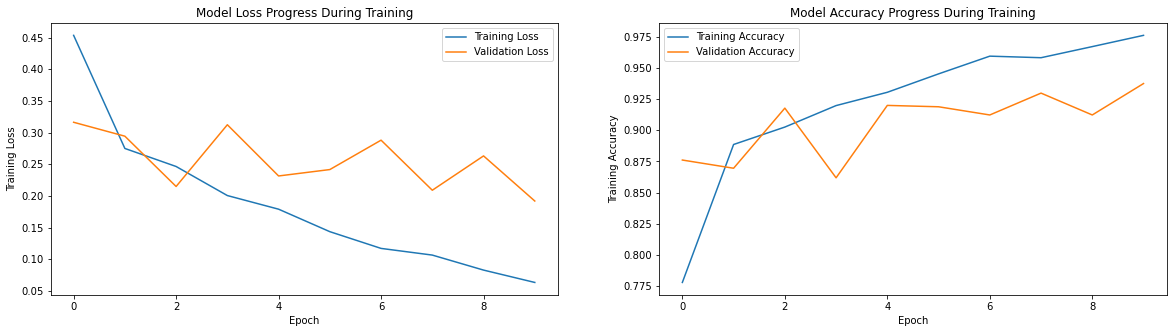

In [285]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend(['Training Loss','Validation Loss'])

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.legend(['Training Accuracy','Validation Accuracy'])

# Evaluate trained model

In [247]:
Test_Directory='Test'

In [291]:
test_generator = ImageDataGenerator(rescale = 1./255)

In [292]:
test_generator = test_generator.flow_from_directory(batch_size =10, directory= Test_Directory, shuffle= False, target_size=(64,64), class_mode= 'binary')

Found 1804 images belonging to 2 classes.


In [293]:
evaluate = cnn.evaluate_generator(test_generator, steps = test_generator.n // 10, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1])) # 0 gives the loss and 1 the accuracy

180/180 [==============================] - 11s 61ms/step - loss: 0.2437 - accuracy: 0.9211
Accuracy Test : 0.9211111068725586


In [294]:
evaluate

[0.24369761155588396, 0.9211111]

In [295]:
pred_probabilities = cnn.predict_generator(test_generator)

In [296]:
pred_probabilities

array([[9.97287035e-01],
       [7.76976347e-04],
       [1.56622231e-02],
       ...,
       [9.92041588e-01],
       [1.05947256e-04],
       [9.91940618e-01]], dtype=float32)

In [297]:
test_generator.classes

array([0, 0, 0, ..., 1, 1, 1])

In [298]:
predictions = pred_probabilities > 0.5 #can be changed according with the precision we want to attain and report 

In [299]:
predictions

array([[ True],
       [False],
       [False],
       ...,
       [ True],
       [False],
       [ True]])

In [300]:
print(classification_report(test_generator.classes,predictions))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92       902
           1       0.97      0.87      0.92       902

    accuracy                           0.92      1804
   macro avg       0.93      0.92      0.92      1804
weighted avg       0.93      0.92      0.92      1804



In [302]:
confusion_matrix(test_generator.classes,predictions)

array([[878,  24],
       [119, 783]], dtype=int64)

# Testing an image

In [376]:
test_path = 'C:/Users/JoaoF/Desktop/kaggle_case_studies/Face mask detection/data/Test/0/without_mask_219.jpg'

In [398]:
my_image = image.load_img(test_path,target_size=(64,64,3))

(-0.5, 63.5, 63.5, -0.5)

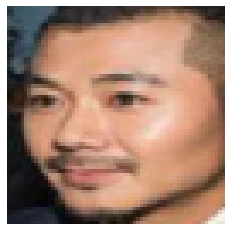

In [405]:
plt.imshow(my_image)
plt.axis('off')

In [379]:
my_image = image.img_to_array(my_image)

In [380]:
my_image.shape

(64, 64, 3)

In [381]:
my_image = np.expand_dims(my_image, axis=0)

In [382]:
my_image.shape

(1, 64, 64, 3)

In [383]:
cnn.predict(my_image)

array([[0.]], dtype=float32)

### Function definition for prediction of a single image

In [419]:
def test_image(path):
    my_image_real = image.load_img(path,target_size=(64,64,3))
    plt.imshow(my_image_real)
    plt.axis('off')
    my_image = image.img_to_array(my_image_real)
    my_image = np.expand_dims(my_image, axis=0)
    prediction = cnn.predict(my_image)
    print(f"The prediction value is {prediction[0][0]}, i.e. {label_names[prediction[0][0]]}") 

The prediction value is 1.0, i.e. With Mask


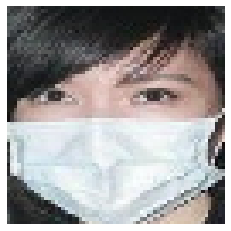

In [420]:
test_image('C:/Users/JoaoF/Desktop/kaggle_case_studies/Face mask detection/data/Test/1/with_mask_5.jpg')